In [22]:
#Attempting to delete all hardcoding from beambeam3d.py and having variables as inputs instead
import numpy as np
from matplotlib import pyplot as plt
import xobjects as xo
import xtrack as xt
import xfieldsdevlumi as xf
import xpart as xp
import time
# Generating sequences

context = xo.ContextCpu()

p0c = 6500e9
bunch_intensity = 0.7825E11
physemit_x = (2.946E-6*xp.PROTON_MASS_EV)/p0c 
physemit_y = (2.946E-6*xp.PROTON_MASS_EV)/p0c 
beta_x = 19.17
beta_y = 19.17
sigma_z = 0.08
sigma_delta = 1E-4
beta_s = sigma_z/sigma_delta
Qx = 64.31
Qy = 59.32
Qs = 2.1E-3
frev = 3070 
nTurn = 3

n_macroparticles = int(100000)
xs_b1 = []
ys_b1 = []
xs_b2 = []
ys_b2 = []
pxs_b1 = []
pys_b1 = []
pxs_b2 = []
pys_b2 = []

pipeline_manager = xt.PipelineManager()
pipeline_manager.add_particles('b1',0)
pipeline_manager.add_particles('b2',0)
pipeline_manager.add_element('IP1')
pipeline_manager.add_element('IP2')

particles_b1 = xp.Particles(_context=context,
    p0c=p0c,
    x=np.sqrt(physemit_x*beta_x)*(np.random.randn(n_macroparticles)),
    px=np.sqrt(physemit_x/beta_x)*np.random.randn(n_macroparticles),
    y=np.sqrt(physemit_y*beta_y)*(np.random.randn(n_macroparticles)),
    py=np.sqrt(physemit_y/beta_y)*np.random.randn(n_macroparticles),
    zeta=sigma_z*np.random.randn(n_macroparticles),
    delta=sigma_delta*np.random.randn(n_macroparticles),
    weight=bunch_intensity/n_macroparticles
)
particles_b1.init_pipeline('b1')
particles_b2 = xp.Particles(_context=context,
    p0c=p0c,
    x=np.sqrt(physemit_x*beta_x)*(np.random.randn(n_macroparticles)),
    px=np.sqrt(physemit_x/beta_x)*np.random.randn(n_macroparticles),
    y=np.sqrt(physemit_y*beta_y)*(np.random.randn(n_macroparticles)),
    py=np.sqrt(physemit_y/beta_y)*np.random.randn(n_macroparticles),
    zeta=sigma_z*np.random.randn(n_macroparticles),
    delta=sigma_delta*np.random.randn(n_macroparticles),
    weight=bunch_intensity/n_macroparticles
)
particles_b2.init_pipeline('b2')

#############
# Beam-beam #
#############
slicer = xf.TempSlicer(sigma_z=sigma_z, n_slices=1, mode = 'shatilov')
config_for_update_b1 = xf.ConfigForUpdateBeamBeamBiGaussian3D(
pipeline_manager=pipeline_manager,
element_name='IP1',
partner_particles_name = 'b2',
slicer=slicer,
update_every=1,
)
config_for_update_b2 = xf.ConfigForUpdateBeamBeamBiGaussian3D(
pipeline_manager=pipeline_manager,
element_name='IP1',
partner_particles_name = 'b1',
slicer=slicer,
update_every=1,
)

IP2_config_for_update_b1 = xf.ConfigForUpdateBeamBeamBiGaussian3D(
pipeline_manager=pipeline_manager,
element_name='IP2',
partner_particles_name = 'b2',
slicer=slicer,
update_every=1,
)
IP2_config_for_update_b2 = xf.ConfigForUpdateBeamBeamBiGaussian3D(
pipeline_manager=pipeline_manager,
element_name='IP2',
partner_particles_name = 'b1',
slicer=slicer,
update_every=1,
)

print('build bb elements...')
bbeam_b1 = xf.BeamBeamBiGaussian3D(
            _context=context,
            other_beam_q0 = particles_b2.q0,
            phi = 0,alpha=0,
            config_for_update = config_for_update_b1,
            flag_numerical_luminosity = 1,
            flag_luminosity = 1,
            n_lumigrid_cells=1500,
            sig_lumigrid_cells=np.sqrt(physemit_x*beta_x),
            range_lumigrid_cells = 24,
            n_macroparticles=n_macroparticles,
            nTurn = nTurn,
            update_lumigrid_sum=1
            )
bbeam_b2 = xf.BeamBeamBiGaussian3D(
            _context=context,
            other_beam_q0 = particles_b1.q0,
            phi = 0,alpha=0,
            config_for_update = config_for_update_b2,
            flag_numerical_luminosity = 1,
            flag_luminosity = 1,
            n_lumigrid_cells=1500,
            sig_lumigrid_cells=np.sqrt(physemit_x*beta_x),
            range_lumigrid_cells = 24,
            n_macroparticles=n_macroparticles,
            nTurn = nTurn,
            update_lumigrid_sum=1
            )
print(n_macroparticles)
IP2_bbeam_b1 = xf.BeamBeamBiGaussian3D(
            _context=context,
            other_beam_q0 = particles_b2.q0,
            phi = 0,alpha=0,
            config_for_update = IP2_config_for_update_b1,
            flag_numerical_luminosity = 0,
            flag_luminosity = 1,
            update_lumigrid_sum=1)
IP2_bbeam_b2 = xf.BeamBeamBiGaussian3D(
            _context=context,
            other_beam_q0 = particles_b1.q0,
            phi = 0,alpha=0,
            config_for_update = IP2_config_for_update_b2,
            flag_numerical_luminosity= 0,
            flag_luminosity = 1,
            update_lumigrid_sum=1)


#################################################################
# arcs (here they are all the same with half the phase advance) #
#################################################################

arc = xt.LineSegmentMap(
        betx = beta_x,bety = beta_y,
        qx = Qx/2, qy = Qy/2,bets = beta_s, qs=Qs)
#################################################################
# Tracker                                                       #
#################################################################
'''
elements_b1 = [bbeam_b1,arc]
elements_b2 = [bbeam_b2,arc]
element_names_b1 = ['bbeam_b1','arc']
element_names_b2 = ['bbeam_b2','arc']
'''
elements_b1 = [bbeam_b1,arc, IP2_bbeam_b1]
elements_b2 = [bbeam_b2,arc, IP2_bbeam_b2]

line_b1 = xt.Line(elements=elements_b1)
line_b2 = xt.Line(elements=elements_b2)
line_b1.build_tracker()
line_b2.build_tracker()
branch_b1 = xt.PipelineBranch(line_b1,particles_b1)
branch_b2 = xt.PipelineBranch(line_b2,particles_b2)


multitracker = xt.PipelineMultiTracker(branches=[branch_b1,branch_b2])


record_qss_b1 = line_b1.start_internal_logging_for_elements_of_type(xf.BeamBeamBiGaussian3D, 
                                                        capacity={
                                                            "beamstrahlungtable": int(0),
                                                            "bhabhatable": int(0),
                                                            "lumitable": nTurn,
                                                            "numlumitable": nTurn
                                                        })


print('Tracking...')
time0 = time.time()

multitracker.track(num_turns=nTurn,turn_by_turn_monitor=True)
print('Done with tracking.',(time.time()-time0)/10,'[s/turn]')
line_b1.stop_internal_logging_for_elements_of_type(xf.BeamBeamBiGaussian3D)

record_qss_b1.move(_context=xo.context_default)


lumi_b1_beambeam = record_qss_b1.lumitable.luminosity
num_lumi_b1_beambeam = bbeam_b1.numlumitable.numerical_luminosity
grid = bbeam_b1.lumigrid_sum
print('Gaussian Luminosity with beam-beam:',frev*lumi_b1_beambeam)
print('Numerical Integrator Luminosity with beam-beam:',num_lumi_b1_beambeam)
print(np.sum(grid))
def Lumi_analytical(Nb, N1, N2, frev, Delta_i, sig_i, sig_x, sig_y):
    W = np.exp(-Delta_i**2/(4*sig_i**2))
    return ((Nb * N1 * N2 * frev * W)/(4 * np.pi * sig_x * sig_y))

print('analytical:',Lumi_analytical(1, bunch_intensity, bunch_intensity, frev, 0,np.sqrt(physemit_x*beta_x), np.sqrt(physemit_x*beta_x), np.sqrt(physemit_y*beta_x)))

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
build bb elements...
100000
Tracking...
lumigrid_my_beam size: (1500, 1500)
exchange_buffer size: (2250017,)
lumigrid_my_beam size: (1500, 1500)
exchange_buffer size: (2250017,)
lumigrid_my_beam size: (1500, 1500)
exchange_buffer size: (2250017,)
lumigrid_my_beam size: (1500, 1500)
exchange_buffer size: (2250017,)
lumigrid_my_beam size: (1500, 1500)
exchange_buffer size: (2250017,)
lumigrid_my_beam size: (1500, 1500)
exchange_buffer size: (2250017,)
Done with tracking. 2.6042131900787355 [s/turn]
Gaussian Luminosity with beam-beam: [0. 0. 0.]
Numerical Integrator Luminosity with beam-beam: [6.67920613e+32 6.71871073e+32 6.69633562e+32]
1.493265870809925e+17
analytical: 6.72151700827703e+32


In [6]:
import numpy as np
from matplotlib import pyplot as plt
import xobjects as xo
import xtrack as xt
import xfieldsdevlumi as xf
import xpart as xp
import time

context = xo.ContextCpu()

p0c = 6500e9
bunch_intensity = 0.7825E11
physemit_x = (2.946E-6*xp.PROTON_MASS_EV)/p0c 
physemit_y = (2.946E-6*xp.PROTON_MASS_EV)/p0c 
beta_x = 19.17
beta_y = 19.17
sigma_z = 0.08
sigma_delta = 1E-4
beta_s = sigma_z/sigma_delta
Qx = 64.31
Qy = 59.32
Qs = 2.1E-3
frev = 11245.5 
nTurn = 3




# Define parameter ranges for scans
n_macroparticles_list = [100, 500, 1000, 5000, 100000, 500000, 1000000, 5000000]
n_lumigrid_cells_list = [10, 20, 50, 100, 200, 500, 1000, 2500] 
lumi_macroparticles = []

for n_macroparticles in n_macroparticles_list: 
    xs_b1 = []
    ys_b1 = []
    xs_b2 = []
    ys_b2 = []
    pxs_b1 = []
    pys_b1 = []
    pxs_b2 = []
    pys_b2 = []

    pipeline_manager = xt.PipelineManager()
    pipeline_manager.add_particles('b1',0)
    pipeline_manager.add_particles('b2',0)
    pipeline_manager.add_element('IP1')
    pipeline_manager.add_element('IP2')

    particles_b1 = xp.Particles(_context=context,
    p0c=p0c,
    x=np.sqrt(physemit_x*beta_x)*(np.random.randn(n_macroparticles)),
    px=np.sqrt(physemit_x/beta_x)*np.random.randn(n_macroparticles),
    y=np.sqrt(physemit_y*beta_y)*(np.random.randn(n_macroparticles)),
    py=np.sqrt(physemit_y/beta_y)*np.random.randn(n_macroparticles),
    zeta=sigma_z*np.random.randn(n_macroparticles),
    delta=sigma_delta*np.random.randn(n_macroparticles),
    weight=bunch_intensity/n_macroparticles
    )
    particles_b1.init_pipeline('b1')
    particles_b2 = xp.Particles(_context=context,
        p0c=p0c,
        x=np.sqrt(physemit_x*beta_x)*(np.random.randn(n_macroparticles)),
        px=np.sqrt(physemit_x/beta_x)*np.random.randn(n_macroparticles),
        y=np.sqrt(physemit_y*beta_y)*(np.random.randn(n_macroparticles)),
        py=np.sqrt(physemit_y/beta_y)*np.random.randn(n_macroparticles),
        zeta=sigma_z*np.random.randn(n_macroparticles),
        delta=sigma_delta*np.random.randn(n_macroparticles),
        weight=bunch_intensity/n_macroparticles
    )
    particles_b2.init_pipeline('b2')

    #############
    # Beam-beam #
    #############
    slicer = xf.TempSlicer(sigma_z=sigma_z, n_slices=1, mode = 'shatilov')
    config_for_update_b1 = xf.ConfigForUpdateBeamBeamBiGaussian3D(
    pipeline_manager=pipeline_manager,
    element_name='IP1',
    partner_particles_name = 'b2',
    slicer=slicer,
    update_every=1,
    )
    config_for_update_b2 = xf.ConfigForUpdateBeamBeamBiGaussian3D(
    pipeline_manager=pipeline_manager,
    element_name='IP1',
    partner_particles_name = 'b1',
    slicer=slicer,
    update_every=1,
    )
    
    IP2_config_for_update_b1 = xf.ConfigForUpdateBeamBeamBiGaussian3D(
    pipeline_manager=pipeline_manager,
    element_name='IP2',
    partner_particles_name = 'b2',
    slicer=slicer,
    update_every=1,
    )
    IP2_config_for_update_b2 = xf.ConfigForUpdateBeamBeamBiGaussian3D(
    pipeline_manager=pipeline_manager,
    element_name='IP2',
    partner_particles_name = 'b1',
    slicer=slicer,
    update_every=1,
    )
    
    print('build bb elements...')

    bbeam_b1 = xf.BeamBeamBiGaussian3D(
                _context=context,
                other_beam_q0 = particles_b2.q0,
                phi = 0,alpha=0,
                config_for_update = config_for_update_b1,
                flag_numerical_luminosity = 1,
                flag_luminosity = 1,
                n_lumigrid_cells=1500,
                sig_lumigrid_cells=np.sqrt(physemit_x*beta_x),
                range_lumigrid_cells = 24,
                n_macroparticles=n_macroparticles,
                nTurn = nTurn,
                update_lumigrid_sum=1
                )
    bbeam_b2 = xf.BeamBeamBiGaussian3D(
                _context=context,
                other_beam_q0 = particles_b1.q0,
                phi = 0,alpha=0,
                config_for_update = config_for_update_b2,
                flag_numerical_luminosity = 1,
                flag_luminosity = 1,
                n_lumigrid_cells=1500,
                sig_lumigrid_cells=np.sqrt(physemit_x*beta_x),
                range_lumigrid_cells = 24,
                n_macroparticles=n_macroparticles,
                nTurn = nTurn,
                update_lumigrid_sum=1
                )
    print(n_macroparticles)

    IP2_bbeam_b1 = xf.BeamBeamBiGaussian3D(
                _context=context,
                other_beam_q0 = particles_b2.q0,
                phi = 0,alpha=0,
                config_for_update = IP2_config_for_update_b1,
                flag_numerical_luminosity = 0,
                flag_luminosity = 1,
                update_lumigrid_sum=1)
    IP2_bbeam_b2 = xf.BeamBeamBiGaussian3D(
                _context=context,
                other_beam_q0 = particles_b1.q0,
                phi = 0,alpha=0,
                config_for_update = IP2_config_for_update_b2,
                flag_numerical_luminosity= 0,
                flag_luminosity = 1,
                update_lumigrid_sum=1)




    #################################################################
    # arcs (here they are all the same with half the phase advance) #
    #################################################################
    
    arc = xt.LineSegmentMap(
            betx = beta_x,bety = beta_y,
            qx = Qx/2, qy = Qy/2,bets = beta_s, qs=Qs)
    #################################################################
    # Tracker                                                       #
    #################################################################

    '''
    elements_b1 = [bbeam_b1,arc]
    elements_b2 = [bbeam_b2,arc]
    element_names_b1 = ['bbeam_b1','arc']
    element_names_b2 = ['bbeam_b2','arc']
    '''
    elements_b1 = [bbeam_b1,arc, IP2_bbeam_b1]
    elements_b2 = [bbeam_b2,arc, IP2_bbeam_b2]
    
    line_b1 = xt.Line(elements=elements_b1)
    line_b2 = xt.Line(elements=elements_b2)
    line_b1.build_tracker()
    line_b2.build_tracker()
    branch_b1 = xt.PipelineBranch(line_b1,particles_b1)
    branch_b2 = xt.PipelineBranch(line_b2,particles_b2)


    multitracker = xt.PipelineMultiTracker(branches=[branch_b1,branch_b2])

    record_qss_b1 = line_b1.start_internal_logging_for_elements_of_type(xf.BeamBeamBiGaussian3D, 
                                                        capacity={
                                                            "beamstrahlungtable": int(0),
                                                            "bhabhatable": int(0),
                                                            "lumitable": nTurn,
                                                            "numlumitable": nTurn
                                                        })


    print('Tracking...')
    time0 = time.time()
    
    multitracker.track(num_turns=nTurn,turn_by_turn_monitor=True)
    print('Done with tracking.',(time.time()-time0)/10,'[s/turn]')
    line_b1.stop_internal_logging_for_elements_of_type(xf.BeamBeamBiGaussian3D)
    
    record_qss_b1.move(_context=xo.context_default)

    lumi_b1_beambeam = record_qss_b1.lumitable.luminosity
    num_lumi_b1_beambeam = bbeam_b1.numlumitable.numerical_luminosity
    grid = bbeam_b1.lumigrid_sum
    print('Gaussian Luminosity with beam-beam:',frev*lumi_b1_beambeam)
    print('Numerical Integrator Luminosity with beam-beam:',num_lumi_b1_beambeam)
    lumi_macroparticles.append(num_lumi_b1_beambeam[0])
    print(np.sum(grid))
    def Lumi_analytical(Nb, N1, N2, frev, Delta_i, sig_i, sig_x, sig_y):
        W = np.exp(-Delta_i**2/(4*sig_i**2))
        return ((Nb * N1 * N2 * frev * W)/(4 * np.pi * sig_x * sig_y))
    
    print('analytical:',Lumi_analytical(1, bunch_intensity, bunch_intensity, frev, 0,np.sqrt(physemit_x*beta_x), np.sqrt(physemit_x*beta_x), np.sqrt(physemit_y*beta_x)))
lumi_macroparticles = np.array(lumi_macroparticles)
print(lumi_macroparticles)

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
build bb elements...
100
Tracking...
lumigrid_my_beam size: (1500, 1500)
exchange_buffer size: (2250017,)
lumigrid_my_beam size: (1500, 1500)
exchange_buffer size: (2250017,)
lumigrid_my_beam size: (1500, 1500)
exchange_buffer size: (2250017,)
lumigrid_my_beam size: (1500, 1500)
exchange_buffer size: (2250017,)
lumigrid_my_beam size: (1500, 1500)
exchange_buffer size: (2250017,)
lumigrid_my_beam size: (1500, 1500)
exchange_buffer size: (2250017,)
Done with tracking. 2.362501788139343 [s/turn]
Gaussian Luminosity with beam-beam: [0. 0. 0.]
Numerical Integrator Luminosity with beam-beam: [4.40130457e+31 4.61639048e+31 3.26007976e+33]
151122292591685.56
analytical: 6.72151700827703e+32
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
build bb elements...
500
Tracking...
lumigrid_my_beam size: (1500, 1500)
exchange_buffer size: (2250017,)
lumigrid_my_beam size: (1500, 1500)
exchange_buffer size: (2250017,)

In [3]:
n_lumigrid_cells_list = [10, 20, 50, 100, 200, 500, 1000, 2500] 
n_macroparticles = 1000
lumi_lumigrid_cells = []

for n_lumigrid_cells in n_lumigrid_cells_list: 
    xs_b1 = []
    ys_b1 = []
    xs_b2 = []
    ys_b2 = []
    pxs_b1 = []
    pys_b1 = []
    pxs_b2 = []
    pys_b2 = []

    pipeline_manager = xt.PipelineManager()
    pipeline_manager.add_particles('b1',0)
    pipeline_manager.add_particles('b2',0)
    pipeline_manager.add_element('IP1')
    pipeline_manager.add_element('IP2')

    particles_b1 = xp.Particles(_context=context,
    p0c=p0c,
    x=np.sqrt(physemit_x*beta_x)*(np.random.randn(n_macroparticles)),
    px=np.sqrt(physemit_x/beta_x)*np.random.randn(n_macroparticles),
    y=np.sqrt(physemit_y*beta_y)*(np.random.randn(n_macroparticles)),
    py=np.sqrt(physemit_y/beta_y)*np.random.randn(n_macroparticles),
    zeta=sigma_z*np.random.randn(n_macroparticles),
    delta=sigma_delta*np.random.randn(n_macroparticles),
    weight=bunch_intensity/n_macroparticles
    )
    particles_b1.init_pipeline('b1')
    particles_b2 = xp.Particles(_context=context,
        p0c=p0c,
        x=np.sqrt(physemit_x*beta_x)*(np.random.randn(n_macroparticles)),
        px=np.sqrt(physemit_x/beta_x)*np.random.randn(n_macroparticles),
        y=np.sqrt(physemit_y*beta_y)*(np.random.randn(n_macroparticles)),
        py=np.sqrt(physemit_y/beta_y)*np.random.randn(n_macroparticles),
        zeta=sigma_z*np.random.randn(n_macroparticles),
        delta=sigma_delta*np.random.randn(n_macroparticles),
        weight=bunch_intensity/n_macroparticles
    )
    particles_b2.init_pipeline('b2')

    #############
    # Beam-beam #
    #############
    slicer = xf.TempSlicer(sigma_z=sigma_z, n_slices=1, mode = 'shatilov')
    config_for_update_b1 = xf.ConfigForUpdateBeamBeamBiGaussian3D(
    pipeline_manager=pipeline_manager,
    element_name='IP1',
    partner_particles_name = 'b2',
    slicer=slicer,
    update_every=1,
    )
    config_for_update_b2 = xf.ConfigForUpdateBeamBeamBiGaussian3D(
    pipeline_manager=pipeline_manager,
    element_name='IP1',
    partner_particles_name = 'b1',
    slicer=slicer,
    update_every=1,
    )
    
    IP2_config_for_update_b1 = xf.ConfigForUpdateBeamBeamBiGaussian3D(
    pipeline_manager=pipeline_manager,
    element_name='IP2',
    partner_particles_name = 'b2',
    slicer=slicer,
    update_every=1,
    )
    IP2_config_for_update_b2 = xf.ConfigForUpdateBeamBeamBiGaussian3D(
    pipeline_manager=pipeline_manager,
    element_name='IP2',
    partner_particles_name = 'b1',
    slicer=slicer,
    update_every=1,
    )
    
    print('build bb elements...')

    bbeam_b1 = xf.BeamBeamBiGaussian3D(
                _context=context,
                other_beam_q0 = particles_b2.q0,
                phi = 0,alpha=0,
                config_for_update = config_for_update_b1,
                flag_numerical_luminosity = 1,
                flag_luminosity = 1,
                n_lumigrid_cells=n_lumigrid_cells,
                sig_lumigrid_cells=np.sqrt(physemit_x*beta_x),
                range_lumigrid_cells = 24,
                n_macroparticles=n_macroparticles,
                nTurn = nTurn,
                update_lumigrid_sum=1
                )
    bbeam_b2 = xf.BeamBeamBiGaussian3D(
                _context=context,
                other_beam_q0 = particles_b1.q0,
                phi = 0,alpha=0,
                config_for_update = config_for_update_b2,
                flag_numerical_luminosity = 1,
                flag_luminosity = 1,
                n_lumigrid_cells=n_lumigrid_cells,
                sig_lumigrid_cells=np.sqrt(physemit_x*beta_x),
                range_lumigrid_cells = 24,
                n_macroparticles=n_macroparticles,
                nTurn = nTurn,
                update_lumigrid_sum=1
                )
    print(n_macroparticles)

    IP2_bbeam_b1 = xf.BeamBeamBiGaussian3D(
                _context=context,
                other_beam_q0 = particles_b2.q0,
                phi = 0,alpha=0,
                config_for_update = IP2_config_for_update_b1,
                flag_numerical_luminosity = 0,
                flag_luminosity = 1,
                update_lumigrid_sum=1)
    IP2_bbeam_b2 = xf.BeamBeamBiGaussian3D(
                _context=context,
                other_beam_q0 = particles_b1.q0,
                phi = 0,alpha=0,
                config_for_update = IP2_config_for_update_b2,
                flag_numerical_luminosity= 0,
                flag_luminosity = 1,
                update_lumigrid_sum=1)




    #################################################################
    # arcs (here they are all the same with half the phase advance) #
    #################################################################
    
    arc = xt.LineSegmentMap(
            betx = beta_x,bety = beta_y,
            qx = Qx/2, qy = Qy/2,bets = beta_s, qs=Qs)
    #################################################################
    # Tracker                                                       #
    #################################################################

    '''
    elements_b1 = [bbeam_b1,arc]
    elements_b2 = [bbeam_b2,arc]
    element_names_b1 = ['bbeam_b1','arc']
    element_names_b2 = ['bbeam_b2','arc']
    '''
    elements_b1 = [bbeam_b1,arc, IP2_bbeam_b1]
    elements_b2 = [bbeam_b2,arc, IP2_bbeam_b2]
    
    line_b1 = xt.Line(elements=elements_b1)
    line_b2 = xt.Line(elements=elements_b2)
    line_b1.build_tracker()
    line_b2.build_tracker()
    branch_b1 = xt.PipelineBranch(line_b1,particles_b1)
    branch_b2 = xt.PipelineBranch(line_b2,particles_b2)


    multitracker = xt.PipelineMultiTracker(branches=[branch_b1,branch_b2])

    record_qss_b1 = line_b1.start_internal_logging_for_elements_of_type(xf.BeamBeamBiGaussian3D, 
                                                        capacity={
                                                            "beamstrahlungtable": int(0),
                                                            "bhabhatable": int(0),
                                                            "lumitable": nTurn,
                                                            "numlumitable": nTurn
                                                        })


    print('Tracking...')
    time0 = time.time()
    
    multitracker.track(num_turns=nTurn,turn_by_turn_monitor=True)
    print('Done with tracking.',(time.time()-time0)/10,'[s/turn]')
    line_b1.stop_internal_logging_for_elements_of_type(xf.BeamBeamBiGaussian3D)
    
    record_qss_b1.move(_context=xo.context_default)

    lumi_b1_beambeam = record_qss_b1.lumitable.luminosity
    num_lumi_b1_beambeam = bbeam_b1.numlumitable.numerical_luminosity
    grid = bbeam_b1.lumigrid_sum
    lumi_macroparticles = []
    print('Gaussian Luminosity with beam-beam:',frev*lumi_b1_beambeam)
    print('Numerical Integrator Luminosity with beam-beam:',num_lumi_b1_beambeam)
    lumi_lumigrid_cells.append(num_lumi_b1_beambeam[0])
    print(np.sum(grid))
    def Lumi_analytical(Nb, N1, N2, frev, Delta_i, sig_i, sig_x, sig_y):
        W = np.exp(-Delta_i**2/(4*sig_i**2))
        return ((Nb * N1 * N2 * frev * W)/(4 * np.pi * sig_x * sig_y))
    
    print('analytical:',Lumi_analytical(1, bunch_intensity, bunch_intensity, frev, 0,np.sqrt(physemit_x*beta_x), np.sqrt(physemit_x*beta_x), np.sqrt(physemit_y*beta_x)))
lumi_lumigrid_cells = np.array(lumi_lumigrid_cells)
print(lumi_lumigrid_cells)
# Combine results into a 2D histogram data
x_vals = np.concatenate((lumi_macroparticles[:, 0], lumi_lumigrid_cells[:, 0]))
y_vals = np.concatenate((lumi_macroparticles[:, 1], lumi_lumigrid_cells[:, 1]))
    
# Plot 2D histogram
plt.figure(figsize=(8, 6))
plt.hist2d(x_vals, y_vals, bins=(len(n_macroparticles_list), len(n_lumigrid_cells_list)), cmap='plasma')
plt.colorbar(label='Luminosity')
plt.xlabel('n_macroparticles / n_lumigrid_cells')
plt.ylabel('Luminosity')
plt.title('2D Histogram of Luminosity vs. Parameters')
plt.show()

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
build bb elements...
1000
Tracking...
lumigrid_my_beam size: (10, 10)
exchange_buffer size: (117,)
lumigrid_my_beam size: (10, 10)
exchange_buffer size: (117,)
lumigrid_my_beam size: (10, 10)
exchange_buffer size: (117,)
lumigrid_my_beam size: (10, 10)
exchange_buffer size: (117,)
lumigrid_my_beam size: (10, 10)
exchange_buffer size: (117,)
lumigrid_my_beam size: (10, 10)
exchange_buffer size: (117,)
Done with tracking. 0.0026784181594848634 [s/turn]
Gaussian Luminosity with beam-beam: [0. 0. 0.]
Numerical Integrator Luminosity with beam-beam: [2.65679485e+32 2.68759437e+32 2.53397414e+32]
53659319068.08001
analytical: 6.72151700827703e+32
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
build bb elements...
1000
Tracking...
lumigrid_my_beam size: (20, 20)
exchange_buffer size: (417,)
lumigrid_my_beam size: (20, 20)
exchange_buffer size: (417,)
lumigrid_my_beam size: (20, 20)
exchange_buffer size: (417

TypeError: list indices must be integers or slices, not tuple

In [7]:
print(lumi_lumigrid_cells)
print(lumi_macroparticles)

[2.65679485e+32 5.07548886e+32 6.32933894e+32 6.55707287e+32
 6.83710885e+32 6.37545360e+32 6.93923308e+32 6.45590611e+32]
[4.40130457e+31 6.98574345e+32 6.48391528e+32 6.78627997e+32
 6.74767412e+32 6.71113028e+32 6.71487747e+32 6.71793958e+32]


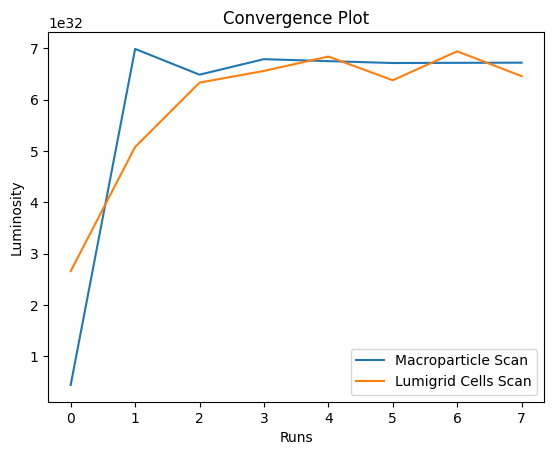

In [11]:
# Combine results into a 2D histogram data
# x_vals = np.concatenate((lumi_macroparticles[:, 0], lumi_lumigrid_cells[:, 0]))
# y_vals = np.concatenate((lumi_macroparticles[:, 1], lumi_lumigrid_cells[:, 1]))

plt.plot(lumi_macroparticles, label="Macroparticle Scan")
plt.plot(lumi_lumigrid_cells, label="Lumigrid Cells Scan")

plt.xlabel("Runs")
plt.ylabel("Luminosity")
plt.title("Convergence Plot")
plt.legend()
plt.show()

# # Plot 2D histogram
# plt.figure(figsize=(8, 6))
# plt.hist2d(x_vals, y_vals, bins=(len(n_macroparticles_list), len(n_lumigrid_cells_list)), cmap='plasma')
# plt.colorbar(label='Luminosity')
# plt.xlabel('n_macroparticles / n_lumigrid_cells')
# plt.ylabel('Luminosity')
# plt.title('2D Histogram of Luminosity vs. Parameters')
# plt.show()